In [1]:
from utils.load import load_mnist
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
from models.CFFNO import CFFNO
from modules.coupling import CouplingLayerFNOv2
from modules.partitions import checkerBoard
from modules.free_net import CNN_Linear, AliasFreeCNN
from torch.distributions.normal import Normal
from modules.act_norm import ActNorm

In [2]:
pos_enc = torch.zeros((64, 2, 4, 4), dtype=torch.float32)
x_coords = torch.arange(4, dtype=torch.float32).view(1, 1, 1, -1)
y_coords = torch.arange(4, dtype=torch.float32).view(1, 1, -1, 1)
pos_enc[:, 0, :, :] = x_coords
pos_enc[:, 1, :, :] = y_coords

In [5]:
pos_enc[0, 1, ...]

tensor([[0., 0., 0., 0.],
        [1., 1., 1., 1.],
        [2., 2., 2., 2.],
        [3., 3., 3., 3.]])

In [2]:
def bilinear_seg(x, modes, step, device):
    x = x.to(device)
    pyramid = [F.interpolate(x, size=(modes, modes), mode='bilinear')]
    B, C, H, W = x.shape
    for i in range((H - modes)//step - 1):
        pyramid.append(F.interpolate(x, size=(modes+(i+1)*step, modes+(i+1)*step), mode='bilinear'))
    pyramid.append(x)
    residual = []
    for i, j in enumerate(pyramid[1:]):
        residual.append(j - F.interpolate(pyramid[i], size=(modes+(i+1)*step, modes+(i+1)*step), mode='bilinear'))
    residual.insert(0, pyramid[0])
    return residual, pyramid

In [3]:
train, test = load_mnist(1, shape_setting=[[8, 1]])

In [4]:
batch = next(iter(train))

In [5]:
x = batch[0].to('cuda')

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal

class NAF(nn.Module):
    def __init__(self, shape, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        encoder = nn.TransformerEncoderLayer(d_model=5, nhead=5, dim_feedforward=2048, dropout=0)
        self.ar = nn.TransformerEncoder(encoder_layer=encoder, num_layers=4)
        self.f0 = nn.Sequential(nn.Linear(5, 16), nn.ReLU(), nn.Linear(16, 16), nn.ReLU(), nn.Linear(16, 32))
        self.prior = Normal(0, 1)
        self.scaling_factor = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, _, height, width = x.size()
        pos_enc = torch.zeros((batch_size, 4, height, width), dtype=torch.float32, device=x.device)

        x_coords = torch.arange(width, dtype=torch.float32, device=x.device).view(1, 1, 1, -1)
        y_coords = torch.arange(height, dtype=torch.float32, device=x.device).view(1, 1, -1, 1)

        pos_enc[:, 0, :, :] = torch.sin(x_coords / 10000)
        pos_enc[:, 1, :, :] = torch.cos(x_coords / 10000)
        pos_enc[:, 2, :, :] = torch.sin(y_coords / 10000)
        pos_enc[:, 3, :, :] = torch.cos(y_coords / 10000)
        start_token = torch.zeros((batch_size, 1, 5), dtype=torch.float32, device=x.device)
        x = torch.cat([x, pos_enc], dim=1)
        x = x.flatten(start_dim=-2, end_dim=-1).permute(0, 2, 1)
        x = torch.cat([start_token, x], dim=1)
        sldj = 0
        logits = []
        s_fac = self.scaling_factor.exp()
        mask_history = []
        st_history = []
        for i in range(x.shape[-2]-1):
            masked = x.clone()[:, :i+2, :]
            masked[:, -1, 0] = -1
            mask_history.append(masked)
            st = self.ar(masked)
            st = st[:, -1, :]
            st = self.f0(st)
            st_history.append(st)
            st = st.view(-1, 2, 16)
            s, t = st.chunk(2, dim=1)
            s = s.split(1, dim=-1)
            t = t.split(1, dim=-1)
            z = x[:, i+1, 0]
            ldj = 0
            for j in range(16):
                scale = s[j].view(-1)
                scale = torch.tanh(scale / s_fac) * s_fac
                shift = t[j].view(-1)
                z = torch.exp(scale) * z.clone() + shift
                ldj += s[j]
            logits.append(z.unsqueeze(-1))
            sldj += ldj.sum()
        z = torch.cat(logits, dim=-1)
        sldj += self.prior.log_prob(z).sum()
        return -sldj, z, mask_history, st_history
    
    def sample(self, num_samples, resolution,  prior, device):
        start_token = torch.zeros((num_samples, 1, 5), dtype=torch.float32, device=device)
        pos_enc = torch.zeros((num_samples, 4, resolution, resolution), dtype=torch.float32, device=device)

        x_coords = torch.arange(resolution, dtype=torch.float32, device=device).view(1, 1, 1, -1)
        y_coords = torch.arange(resolution, dtype=torch.float32, device=device).view(1, 1, -1, 1)

        pos_enc[:, 0, :, :] = torch.sin(x_coords / 10000)
        pos_enc[:, 1, :, :] = torch.cos(x_coords / 10000)
        pos_enc[:, 2, :, :] = torch.sin(y_coords / 10000)
        pos_enc[:, 3, :, :] = torch.cos(y_coords / 10000)
        x = -torch.ones((num_samples, 1, resolution, resolution), dtype=torch.float32, device=device)
        x = torch.cat([x, pos_enc], dim=1)
        x = x.flatten(start_dim=-2, end_dim=-1).permute(0, 2, 1)
        x = torch.cat([start_token, x], dim=1)
        s_fac = self.scaling_factor.exp().view(1, -1, 1, 1)
        mask_history = []
        st_history = []
        for i in range(x.shape[-2]-1):
            masked = x[:, :i+2, :]
            mask_history.append(masked.clone())
            st = self.ar(masked)
            st = st[:, -1, :]
            st = self.f0(st)
            st_history.append(st)
            st = st.view(-1, 2, 16)
            s, t = st.chunk(2, dim=1)
            s = s.split(1, dim=-1)
            t = t.split(1, dim=-1)
            z = prior[...,i].view(-1)
            for j in range(16):
                scale = s[-j-1].view(-1)
                scale = torch.tanh(scale / s_fac) * s_fac
                shift = t[-j-1].view(-1)
                z = (z - shift) / torch.exp(scale)
            x[:, i+1, 0] = z
            print(x.shape)
        return x[:, 1:, 0].view(num_samples, 1, resolution, resolution), mask_history, st_history

In [7]:
model = NAF(shape=0).to('cuda')
_, z, mh0, sh0 = model(x)

In [8]:
orig, mh1, sh1 = model.sample(1, 8, z[0].unsqueeze(0), 'cuda')

torch.Size([1, 65, 5])
torch.Size([1, 65, 5])
torch.Size([1, 65, 5])
torch.Size([1, 65, 5])
torch.Size([1, 65, 5])
torch.Size([1, 65, 5])
torch.Size([1, 65, 5])
torch.Size([1, 65, 5])
torch.Size([1, 65, 5])
torch.Size([1, 65, 5])
torch.Size([1, 65, 5])
torch.Size([1, 65, 5])
torch.Size([1, 65, 5])
torch.Size([1, 65, 5])
torch.Size([1, 65, 5])
torch.Size([1, 65, 5])
torch.Size([1, 65, 5])
torch.Size([1, 65, 5])
torch.Size([1, 65, 5])
torch.Size([1, 65, 5])
torch.Size([1, 65, 5])
torch.Size([1, 65, 5])
torch.Size([1, 65, 5])
torch.Size([1, 65, 5])
torch.Size([1, 65, 5])
torch.Size([1, 65, 5])
torch.Size([1, 65, 5])
torch.Size([1, 65, 5])
torch.Size([1, 65, 5])
torch.Size([1, 65, 5])
torch.Size([1, 65, 5])
torch.Size([1, 65, 5])
torch.Size([1, 65, 5])
torch.Size([1, 65, 5])
torch.Size([1, 65, 5])
torch.Size([1, 65, 5])
torch.Size([1, 65, 5])
torch.Size([1, 65, 5])
torch.Size([1, 65, 5])
torch.Size([1, 65, 5])
torch.Size([1, 65, 5])
torch.Size([1, 65, 5])
torch.Size([1, 65, 5])
torch.Size(

In [9]:
orig.shape

torch.Size([1, 1, 8, 8])

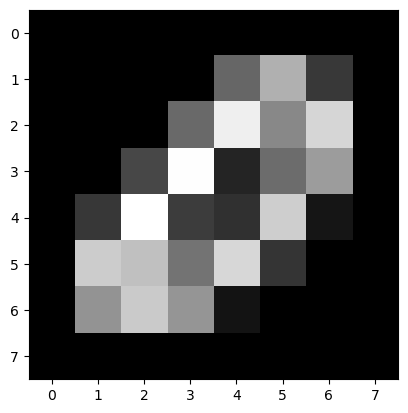

In [10]:
plt.imshow(x[0, 0].detach().cpu().numpy(), cmap='gray')

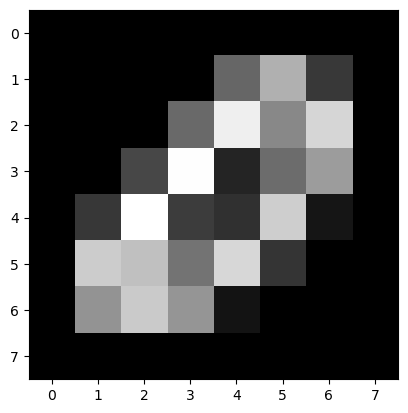

In [11]:
plt.imshow(orig[0, 0].detach().cpu().numpy(), cmap='gray')

In [12]:
print(torch.max(torch.abs(orig - x)))

tensor(4.5776e-05, device='cuda:0', grad_fn=<MaxBackward1>)


In [13]:
print(sh0[0], "\n", sh1[0])

tensor([[-0.1797,  0.0615,  0.0771, -0.1012,  0.1451,  0.0968,  0.0608, -0.2119,
          0.2816,  0.0007, -0.2213, -0.3403,  0.1698, -0.2360, -0.1988,  0.0878,
         -0.1438, -0.0517, -0.2423,  0.2383, -0.1863, -0.1695,  0.0787,  0.0332,
          0.1772, -0.1735,  0.0736,  0.1715, -0.1427,  0.1486, -0.0875, -0.1606]],
       device='cuda:0', grad_fn=<AddmmBackward0>) 
 tensor([[-0.1797,  0.0615,  0.0771, -0.1012,  0.1451,  0.0968,  0.0608, -0.2119,
          0.2816,  0.0007, -0.2213, -0.3403,  0.1698, -0.2360, -0.1988,  0.0878,
         -0.1438, -0.0517, -0.2423,  0.2383, -0.1863, -0.1695,  0.0787,  0.0332,
          0.1772, -0.1735,  0.0736,  0.1715, -0.1427,  0.1486, -0.0875, -0.1606]],
       device='cuda:0', grad_fn=<AddmmBackward0>)


In [14]:
print(torch.max(torch.abs(sh0[0] - sh1[0])))

tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)
